In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, pickle
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import bptt_rnn as bp  # RNN, learning algorithm, loss function etc
import plot_routines as pr  # plotting functions & directly related
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

In [2]:
single_time_labels = ['0', 'A', '0', 'B', '0', 'C', '0', 'D', '0']
double_time_labels = []
double_time_labels_half = []
for stl in single_time_labels:
    double_time_labels.append(stl)
    double_time_labels.append(stl)
    double_time_labels_half.append(stl)
    double_time_labels_half.append('')
double_time_labels_blank = [x.replace('0', '') for x in double_time_labels]
single_time_labels_blank = [x.replace('0', '') for x in single_time_labels]
assert len(double_time_labels_half) == len(double_time_labels)

##  Task design

Trials consist of a sequence: 

$ A_{\alpha} \to B_{\alpha} \to C_{\beta} \to D$, where $\alpha, \beta \in (1, 2)$

Stimuli are interleaved with blanks $0$; e.g. $seq = (z_0, z_1, z_2, ... , z_8) = ( 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 )$
Sequences can either be <em>expected</em>: $\alpha = \beta$ (the majority of trials) or <em>unexpected</em> $\alpha \neq \beta$ (remainder or trials).

We train a neural network to predict the next stimulus $z_{t+1}$ given the current stimulus $z_t$.

## Create synthetic data
There are 8 possible values: 
- 0 $blank/0$
- 1 $A_1$
- 2 $A_2$
- 3 $B_1$
- 4 $B_2$
- 5 $C_1$
- 6 $C_2$
- 7 $D$

Data points are thus 8-dim vectors, with:

$z_{k, t} = (1_{0}, 1_{A_1}, 1_{A_2}, ... , 1_{D})$

where $k$ is the trial index, and $t$ is the trial time. Hence $|z_{k, t}| = 1 $. The goal of the task is to predict $z_{k, t+1}$ given its own state and $z_{k, t}$.

Trials will be either $T=9$ data points long (single), and of form:

$ 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 $

or of length $T=18$ (double), and of form:

$ 0, 0, A_{\alpha}, A_{\alpha}, 0, 0, B_{\alpha}, B_{\alpha}, 0, 0, C_{\beta}, C_{\beta}, 0, 0, D, D, 0, 0 $

where $\alpha, \beta \in (1, 2)$, although one can use shorter sequences for testing (e.g. $0, A_{\alpha}, 0, B_{\alpha}, 0$). The expected sequence is $\alpha = \beta$, and the unexpected sequence is $\alpha \neq \beta$.

Network input $x_k = z_{k, 0:T-1} + \epsilon$ and output $y_k = z_{k, 1:T}$, where $\epsilon \sim N(0, \sigma_x)$.

In [3]:
d_dict = {  # data parameters dictionary
        'n_total': 1000,  # total number of data sequences
        'n_freq': 8,  # blank through D
        'n_times': 9,
        'doublesse': True,
        'ratio_train': 0.8,
        'ratio_exp': 0.75,  # probabilities of switching between alpha nd beta
        'noise_scale': 0.15
        }
if d_dict['doublesse']:
    eval_times = np.arange(4, 17)  # double
    d_dict['sequence'] = np.array(double_time_labels)
elif d_dict['doublesse'] is False:
    eval_times = np.arange(1, 8)  # single
    d_dict['sequence'] = np.array(single_time_labels)
t_dict = {'eval_times': eval_times}  # training paramter dictionary

freq_labels = ['0', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D']
tmp0, tmp1 = bp.generate_synt_data(n_total=d_dict['n_total'], 
                                   n_times=d_dict['n_times'], 
                                   n_freq=d_dict['n_freq'],
                                   ratio_train=d_dict['ratio_train'], 
                                   ratio_exp=d_dict['ratio_exp'], 
                                   noise_scale=d_dict['noise_scale'], 
                                   double_length=d_dict['doublesse'])
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

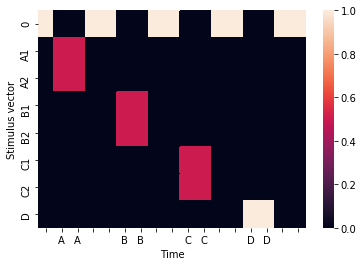

In [4]:
# x_train[:, :, 0] = 0
# x_test[:, :, 0] = 0
# y_train[:, :, 0] = 0
# y_test[:, :, 0] = 0
pr.plot_example_trial(y_train.mean(0))

## RNN Model with BPTT

#### RNN model:

$(x_t, r_{t-1}) \to r_t \to \hat{y}_t == y_t = x_{t+1} $

within one trial $k$. 
Equations:

$r_t = \tanh( U \cdot x_t + W \cdot r_{t-1})$


$\hat{y}_t = softmax(V \cdot r_t) = \left( \frac{e^{V_i \cdot r_t}}{\sum_i e^{V_i \cdot r_t}} \right), \; for \; i \in (0, A_1, A_2 ... D)$

where $U_{n x f}, W_{n x n}, V_{f x n}$ are matrices where $n$ is the number of RNN nodes and $f$ the number of input/output frequencies.

#### Training procedure:

The full sequence $x_k$ is forwarded through the model, yielding $\hat{y}_k$. This is used to compute the loss function $L$, which error is backpropagated through time (BPTT) to the parameters $\theta = (U, W, V)$ (updated with SGD probably). 
The loss function $L$ uses cross entropy and L1 regularisation:

$L_k = \sum_{\tau} - y_{k, \tau} \log \hat{y}_{k, \tau} + \lambda \cdot ||\theta||_1$

where $\tau$ defines the trial times that are taken into account for Loss computation. We set $\tau$ to all trial times _after_ the $A_{\alpha}$ stimuli have occured.

<!-- $ \begin{equation}
    \tau =
    \begin{cases}
      (0, 1, 2, ... 8), & \text{all} \\
      (1, 3, 5, 7), & \text{non-blank (nb)}\\
      (3, 5, 7), & \text{non-initial nb (ninb)}
    \end{cases}
  \end{equation}$
-->
#### Initial conditions:

We initialise $s_0$ with random values drawn from $N(0, 0.1)$ (for each trial individually).


#### Pseudo-algorithm:

    for $it$ in epochs:
        for $k$ in trials:
            for $t$ in times:
                rnn.forward($x_t$)
            compute loss $L_k$
            update parameters with BPTT


In [5]:
## Set training parameters:
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
if d_dict['doublesse']:
    t_dict['learning_rate'] = 0.002  # algorithm lr
elif d_dict['doublesse'] is False:
    t_dict['learning_rate'] = 0.05
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 40  # training epochs
t_dict['l1_param'] = 5e-3  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 


## Train one single model

In [18]:
## Initiate RNN model
rnn = bp.RNN(n_stim=d_dict['n_freq'], n_nodes=t_dict['n_nodes'])  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

In [19]:
## Train with BPTT
rnn = bp.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

Epoch 39/40. Train loss: 1.313704: 100%|██████████| 40/40 [03:22<00:00,  5.05s/it]     

Training finished. Results saved in RNN Class


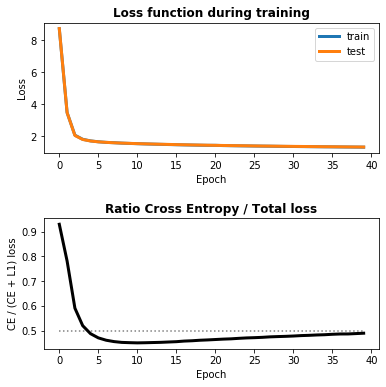

In [21]:
## Plot train/test loss during training
plt.rcParams['figure.figsize'] = (6, 6)
plt.subplots_adjust(hspace=0.5)
# plt.subplot(211)
ax_conv = pr.plot_train_test_perf(rnn_model=rnn, ax=plt.subplot(211))
# plt.ylim([1.2, 2])
ax_conv.set_title('Loss function during training', weight='bold')
plt.subplot(212)
plt.plot(np.arange(rnn.info_dict['trained_epochs']), 
         np.zeros_like(rnn.test_loss_ratio_ce) + 0.5, c='grey', linestyle=':')
plt.plot(rnn.test_loss_ratio_ce, linewidth=3, c='k')
plt.xlabel('Epoch'); plt.ylabel('CE / (CE + L1) loss');
plt.title('Ratio Cross Entropy / Total loss', weight='bold');
# plt.savefig('figures/convergence_training.pdf', bbox_inches='tight')

In [9]:
print(labels_test)

['21' '11' '22' '11' '22' '22' '22' '22' '22' '21' '22' '22' '11' '22'
 '12' '11' '11' '22' '11' '11' '11' '22' '22' '12' '22' '11' '11' '22'
 '22' '22' '11' '22' '11' '22' '21' '22' '11' '11' '11' '11' '11' '22'
 '11' '22' '11' '11' '12' '22' '22' '21' '21' '11' '11' '12' '22' '22'
 '21' '12' '12' '22' '21' '12' '12' '22' '11' '11' '22' '11' '22' '21'
 '22' '22' '11' '22' '12' '11' '22' '12' '11' '11' '22' '11' '11' '22'
 '22' '11' '11' '22' '11' '11' '12' '22' '12' '22' '21' '11' '22' '22'
 '11' '11' '22' '21' '22' '22' '21' '22' '11' '22' '11' '11' '11' '22'
 '11' '12' '11' '11' '22' '12' '22' '11' '11' '22' '21' '11' '12' '11'
 '12' '11' '21' '22' '12' '11' '11' '22' '11' '12' '22' '11' '22' '11'
 '22' '22' '12' '11' '21' '11' '11' '11' '21' '12' '11' '22' '11' '22'
 '11' '22' '21' '22' '22' '22' '22' '11' '22' '22' '21' '22' '12' '11'
 '22' '22' '11' '11' '21' '22' '11' '21' '11' '12' '11' '22' '22' '11'
 '21' '21' '21' '11' '12' '22' '11' '11' '21' '21' '12' '22' '21' '11'
 '22' 

torch.Size([17, 8])


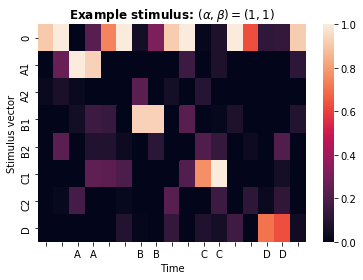

In [186]:
plt.rcParams['figure.figsize'] = (6, 4)
k = 5

print(x_test[k, :, :].shape)
# x_test[k, np.array([2, 3]), 1] = 0
# x_test[k, np.array([2, 3]), 7] = 1
# x_test[k, np.array([6, 7]), 3] = 0
# x_test[k, np.array([6, 7]), 7] = 0
pr.plot_example_trial(x_test[k, :, :], xticklabels=double_time_labels_blank[:-1])
plt.title(r"Example stimulus: $(\alpha, \beta) = (1, 1)$", weight='bold')
plt.savefig('figures/example_stim.pdf', bbox_inches='tight')

Trial type: ['12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12'
 '12' '12' '12' '12' '12' '12' '12' '12' '12' '12' '12']


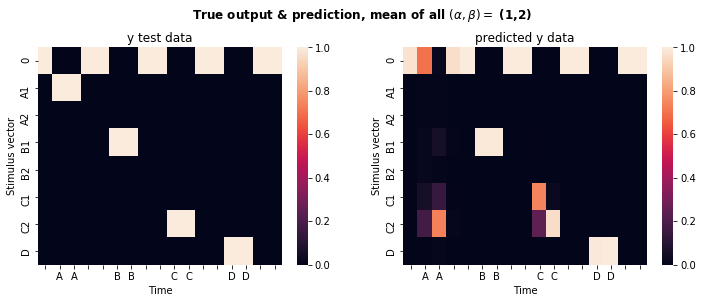

In [25]:
## Plot example test sample & prediction
k = np.where(labels_test == '12')[0]
print(f'Trial type: {labels_test[k]}')
pred = bp.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions
plt.rcParams['figure.figsize'] = (12, 4)

ax_true = plt.subplot(121)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
            xticklabels=double_time_labels_blank[1:])
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(122)
pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
           xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");
plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

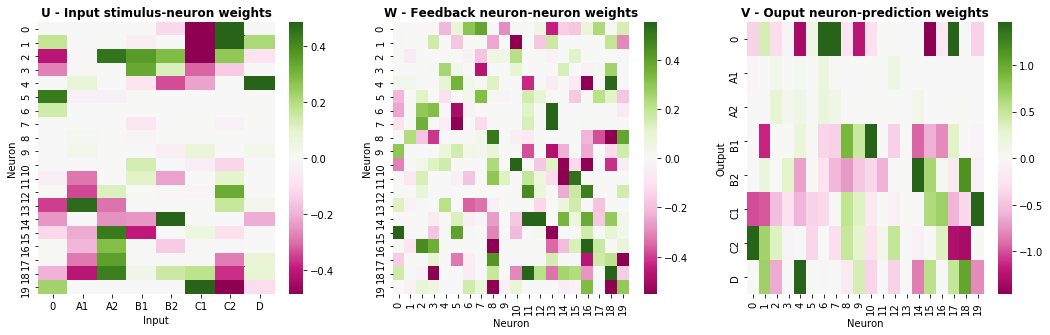

In [26]:
## Plot weight matrices U, W, V
plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=w_order)

## Cross temporal decoding

Each sequence $seq_k$ has labels $\alpha, \beta$. We wish to decode $\alpha$ dynamically per time point, in a cross-temporal manner, from the RNN hidden state $s_t$. Id est, we create a decoder $dec(t | \tau) = P(\alpha = 1 | \tau)_t$ that is trained at time $\tau$ but evaluated at time $t$. We can choose to train our decoder with either or both $(\alpha = \beta)$ and $(\alpha \neq \beta)$ sequences. To decode, we will use a logistic regression with L1 regularisation (from sklearn). 

#### Pseudocode

    forward run of all trials
    for $\tau$ in T:
        train P($\alpha$ | $\tau$)
        for t in T:
            evaluate P($\alpha$ | $\tau$)_t

In [32]:
score_mat, decoder_dict = bp.train_decoder(rnn_model=rnn, x_train=x_train, x_test=x_test,
                                           labels_train=labels_train, labels_test=labels_test)

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


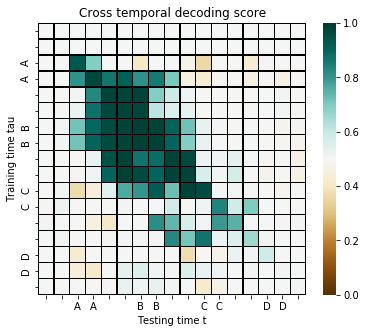

In [34]:
# score_mat[0, 5] = -10
plt.rcParams['figure.figsize'] = (6, 5)
ax_score = pr.plot_decoder_crosstemp_perf(score_matrix=score_mat, ax=plt.subplot(111),
                               ticklabels=double_time_labels_blank[:-1])

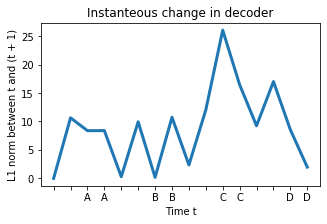

In [35]:
angle_change = np.zeros(x_train.shape[1] - 1)
for tau in range(x_train.shape[1] - 1):
    angle_change[tau] = np.sum(np.abs(decoder_dict[tau].coef_ - decoder_dict[tau + 1].coef_))
    
plt.rcParams['figure.figsize'] = (5, 3)
f, ax_ac = plt.subplots(1, 1)
ax_ac.plot(angle_change, linewidth=3)
ax_ac.set_xlabel('Time t'); ax_ac.set_ylabel('L1 norm between t and (t + 1)')
ax_ac.set_title('Instanteous change in decoder')
ax_ac.set_xticks(np.arange(len(angle_change)));
ax_ac.set_xticklabels(double_time_labels_blank[:-2]);

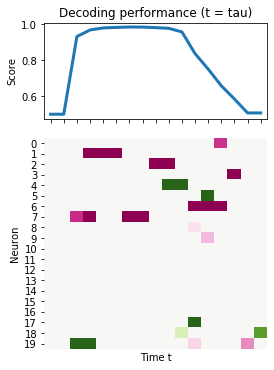

In [36]:
plt.rcParams['figure.figsize'] = (4, 6)
_, __ = pr.plot_dynamic_decoding_axes(rnn=rnn)

## Train & save multiple models

In [6]:
## Train a lot of models for saving:
_ = bp.init_train_save_rnn(t_dict=t_dict, d_dict=d_dict, 
                           n_simulations=11, save_folder='models/60-40_89models/')

Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]


-----------
simulation 0/11


Epoch 39/40. Train loss: 1.401726: 100%|██████████| 40/40 [03:00<00:00,  4.51s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0107.data

-----------
simulation 1/11


Epoch 39/40. Train loss: 1.402774: 100%|██████████| 40/40 [03:26<00:00,  5.16s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0111.data

-----------
simulation 2/11


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0114.data

-----------
simulation 3/11


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0117.data

-----------
simulation 4/11


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0120.data

-----------
simulation 5/11


Epoch 39/40. Train loss: 1.454728: 100%|██████████| 40/40 [03:02<00:00,  4.56s/it]     
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0123.data

-----------
simulation 6/11


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0126.data

-----------
simulation 7/11


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0129.data

-----------
simulation 8/11


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0132.data

-----------
simulation 9/11


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as rnn_2020-05-18-0135.data

-----------
simulation 10/11


Epoch 39/40. Train loss: 1.398394: 100%|██████████| 40/40 [03:01<00:00,  4.54s/it]     


RNN model saved as rnn_2020-05-18-0138.data


In [49]:
## Retrain decoders:
_ = bp.train_multiple_decoders(rnn_folder='models/75-25_100models/', n_samples=1000)

0it [00:00, ?it/s]

train labels  {'11': 200, '12': 200, '21': 200, '22': 200}


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
2it [00:03,  1.66s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
3it [00:04,  1.62s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
7it [00:11,  1.57s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/l

59it [01:38,  1.72s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
60it [01:39,  1.72s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
63it [01:44,  1.68s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
67it [01:51,  1.69s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
68it

In [50]:
agg_conv, agg_score, agg_decoder_mat, agg_weights = {}, {}, {}, {}
folder_dict = {50: 'models/50-50_100models/', 75: 'models/75-25_100models/',
               90: 'models/90-10_100models/', 60: 'models/60-40_100models/',
               100:'models/100-0_100models/'}
folder_dict = {kk: folder_dict[kk] for kk in np.sort(list(folder_dict.keys()))}
for kk, vv in folder_dict.items():
    agg_conv[kk] = bp.aggregate_convergence(model_folder=vv)
    agg_score[kk] = bp.aggregate_score_mats(model_folder=vv)
    agg_decoder_mat[kk] = bp.aggregate_decoders(model_folder=vv)
    agg_weights[kk] = bp.aggregate_weights(model_folder=vv, weight='U')

<Figure size 720x1296 with 0 Axes>

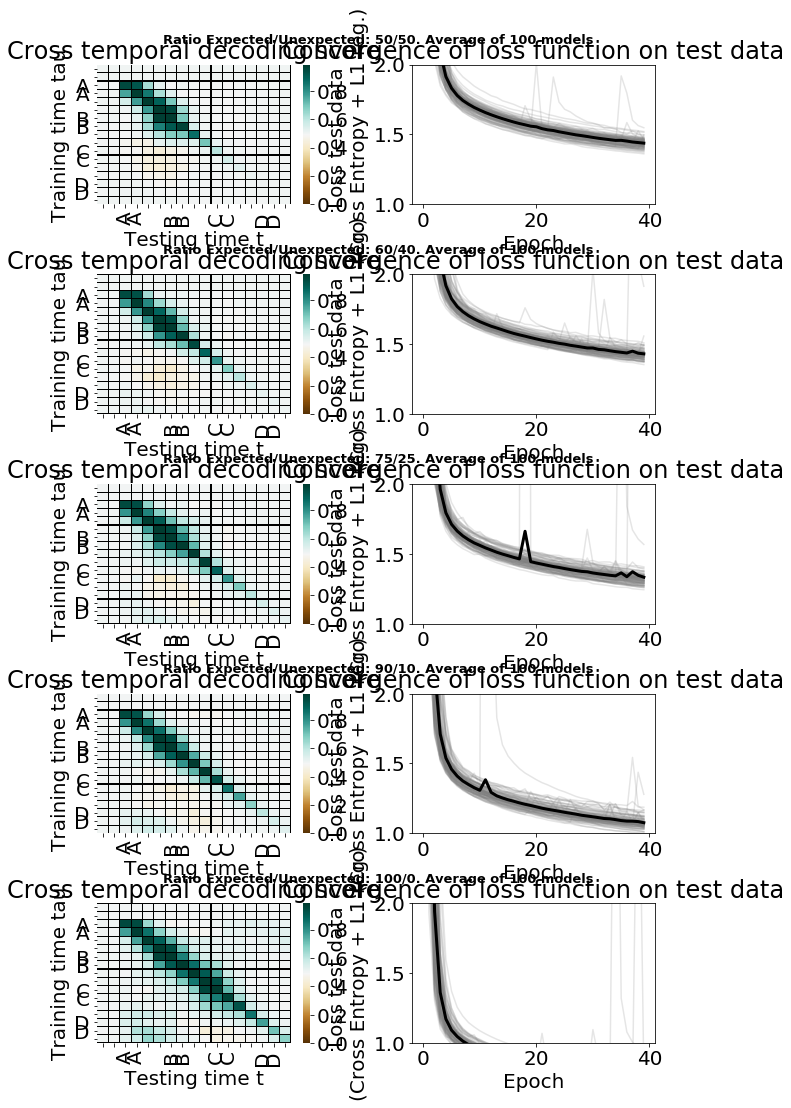

In [51]:
plt.rcParams['figure.figsize'] = (10, 18)
plt.subplots_adjust(hspace=0.6)
fig, ax_agg = plt.subplots(len(folder_dict), 2)
for i_ax, kk in enumerate(list(agg_conv.keys())):
    model_selection = np.arange(agg_score[kk].shape[0])
#     model_selection = agg_score[kk][:, 11, 6] < 0.4
#     plot_mat = np.mean(np.abs(agg_score[kk][model_selection, :, :] - 0.5) + 0.5, 0)
    plot_mat = np.mean(agg_score[kk][model_selection, :, :], 0)
    pr.plot_decoder_crosstemp_perf(score_matrix=plot_mat, 
                                   ax=ax_agg[i_ax][0], ticklabels=double_time_labels_blank[:-1])

    ax_agg[i_ax][1].plot(agg_conv[kk]['test'][:100, :].T, alpha=0.2, c='grey')
    ax_agg[i_ax][1].plot(np.mean(agg_conv[kk]['test'], 0), linewidth=3, c='k')
    ax_agg[i_ax][1].set_ylim([1, 2]); 
    ax_agg[i_ax][1].set_ylabel('Loss test data \n(Cross Entropy + L1 reg.)')
    ax_agg[i_ax][1].set_xlabel('Epoch'); ax_agg[i_ax][1].set_title('Convergence of loss function on test data');
    ax_agg[i_ax][1].text(s=f'Ratio Expected/Unexpected: {kk}/{100 - kk}. Average of {agg_score[kk].shape[0]} models',
                         x=-46, y=2.15, fontdict={'weight': 'bold', 'fontsize': 13})
fig.subplots_adjust(hspace=0.5, wspace=0.3)
# plt.savefig('results/average_results_new.pdf', bbox_inches='tight')

In [181]:
low_bound = 0.4
high_bound = 0.6
agg_score_use = agg_score[75]
corr_names = {'low': 'anti-correlated', 'med': 'decorrelated',
              'high': 'correlated'}
train_times = np.arange(8, 11)
test_times = np.arange(6, 8)
summ_accuracy = agg_score_use[:, train_times, :][:, :, test_times].mean((1, 2))

inds_sel = {'low': np.where(summ_accuracy < low_bound)[0],
            'med': np.where(np.logical_and(summ_accuracy >= low_bound,
                                           summ_accuracy <= high_bound))[0],
            'high': np.where(summ_accuracy > high_bound)[0]}

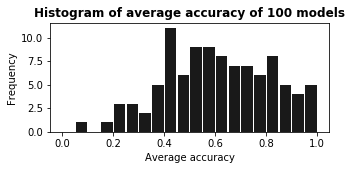

In [180]:
plt.rcParams['figure.figsize'] = (5, 2)
plt.xlabel('Average accuracy')
plt.ylabel('Frequency'); plt.title('Histogram of average accuracy of 100 models', weight='bold')
# plt.vlines(x=0.4, ymin=0, ymax=10, color='m', linewidth=3)
# plt.vlines(x=0.6, ymin=0, ymax=10, color='b', linewidth=3)
# plt.axvspan(xmin=0, xmax=0.4, alpha=0.2, color='blue')
# plt.axvspan(xmin=0.4, xmax=0.6, alpha=0.2, color='blue')
# plt.axvspan(xmin=0.6, xmax=1, alpha=0.2, color='blue')

plt.hist(summ_accuracy, color='k', bins=np.linspace(0, 1, 21), 
         rwidth=0.9, alpha=0.9)
plt.savefig('figures/histogram_accuracy.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

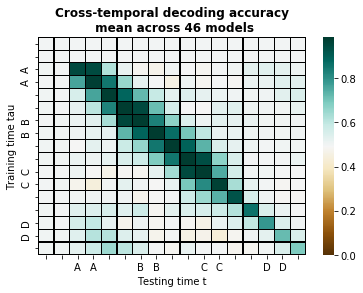

In [9]:
# single matrix

plt.rcParams['figure.figsize'] = (6, 4)
plt.subplots_adjust(hspace=0.6)
# fig, ax_agg = plt.subplots(len(folder_dict), 2)
fig, ax_agg = plt.subplots(1, 1)
# model_selection = np.ones(agg_score[kk].shape[0], dtype='bool')
# model_selection = agg_score_use[:, 10, 6] > 0.6
model_selection = inds_sel['high']
plot_mat = np.mean(agg_score[kk][model_selection, :, :], 0)
pr.plot_decoder_crosstemp_perf(score_matrix=plot_mat, 
                               ax=ax_agg, ticklabels=double_time_labels_blank[:-1])

#     ax_agg[1].plot(agg_conv[kk]['test'][:100, :].T, alpha=0.2, c='grey')
#     ax_agg[1].plot(np.mean(agg_conv[kk]['test'], 0), linewidth=3, c='k')
#     ax_agg[1].set_ylim([1, 2]); 
#     ax_agg[1].set_ylabel('Loss test data \n(Cross Entropy + L1 reg.)')
#     ax_agg[1].set_xlabel('Epoch'); ax_agg[1].set_title('Convergence of loss function on test data');
#     ax_agg[1].text(s=f'Ratio Expected/Unexpected: {kk}/{100 - kk}. Average of {agg_score[kk].shape[0]} models',
#                          x=-46, y=2.15, fontdict={'weight': 'bold', 'fontsize': 13})
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax_agg.set_title(f'Cross-temporal decoding accuracy\n mean across {np.sum(model_selection > 0)} models', weight='bold');
# plt.savefig('figures/decoding_matrix_high.pdf', bbox_inches='tight')

(0, 17)

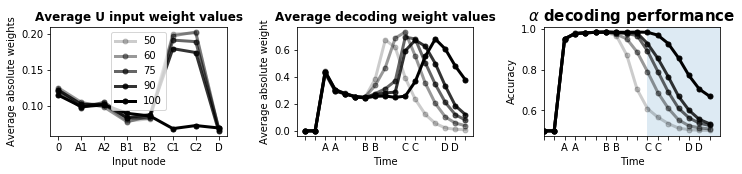

In [6]:
plt.rcParams['figure.figsize'] = (12, 2)
plt.subplots_adjust(wspace=0.4)

# list_ratios = list(agg_weights.keys())
alpha_dict = {x: 0.2 + 0.2 * i_kk for i_kk, x in enumerate(agg_weights.keys())}
list_ratios = list(agg_weights.keys()) #[75]
ax_abs_w = plt.subplot(131)
for i_kk, kk in enumerate(list_ratios):
    ax_abs_w.plot(np.mean(agg_weights[kk], 0), alpha=alpha_dict[kk], color='k',
                  marker='.', linewidth=3, markersize=10, label=kk)
#     ax_abs_w.bar(x=freq_labels, height=np.mean(agg_weights[kk], 0))
plt.legend(); ax_abs_w.set_xticks(np.arange(agg_weights[kk].shape[1]));
ax_abs_w.set_xticklabels(freq_labels); ax_abs_w.set_ylabel('Average absolute weights')
ax_abs_w.set_title('Average U input weight values', weight='bold')
ax_abs_w.set_xlabel('Input node')

ax_dec_w = plt.subplot(132)
for i_kk, kk in enumerate(list_ratios):
    ax_dec_w.plot(np.abs(agg_decoder_mat[kk]).mean((0, 1)), alpha=alpha_dict[kk], color='k',
                  marker='.', linewidth=3, markersize=10, label=kk)
ax_dec_w.set_xticks(np.arange(agg_decoder_mat[75].shape[2]))
ax_dec_w.set_xticklabels(double_time_labels_blank[:-1]);
ax_dec_w.set_xlabel('Time'); ax_dec_w.set_ylabel('Average absolute weight');
ax_dec_w.set_title('Average decoding weight values', weight='bold')

ax_dec_w = plt.subplot(133)
for i_kk, kk in enumerate(list_ratios):
    ax_dec_w.plot(np.diag(agg_score[kk].mean(0)), alpha=alpha_dict[kk], color='k',
                  marker='.', linewidth=3, markersize=10, label=kk)
ax_dec_w.set_xticks(np.arange(agg_decoder_mat[75].shape[2]))
ax_dec_w.set_xticklabels(double_time_labels_blank[:-1]);
ax_dec_w.set_xlabel('Time'); ax_dec_w.set_ylabel('Accuracy');
ax_dec_w.set_title(r'$\alpha$ decoding performance', weight='bold', fontsize=15);
ax_dec_w.axvspan(xmin=10, xmax=17, alpha=0.15)
ax_dec_w.set_xlim([0, 17])
# ax_abs_w.text(s='A', x=-2, y=0.22, fontdict={'fontsize': 20, 'weight':'bold'})
# ax_abs_w.text(s='B', x=8.5, y=0.22, fontdict={'fontsize': 20, 'weight':'bold'})
# ax_abs_w.text(s='C', x=19.5, y=0.22, fontdict={'fontsize': 20, 'weight':'bold'})

# plt.savefig('figures/details_ratio_exp_all.pdf', bbox_inches='tight')

In [20]:


beta_diag = np.diag(agg_score[75].mean(0)).copy()
# alpha_diag = np.diag(agg_score[75].mean(0)).copy()

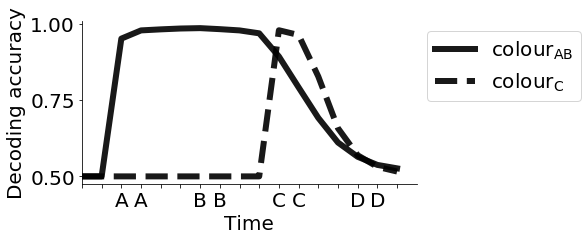

In [48]:
kk= 75
alpha_dict[kk] = 0.9
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['font.size'] = 20
ax_dec_w = plt.subplot(111)
ax_dec_w.plot(alpha_diag, alpha=alpha_dict[kk], color='k',
              marker='', linewidth=6, markersize=18, label=r"colour$\mathregular{_{AB}}$")
ax_dec_w.plot(beta_diag, alpha=alpha_dict[kk], color='k', linestyle='--',
              marker='', linewidth=6, markersize=18, label=r'colour$\mathregular{_C}$')
ax_dec_w.set_xticks(np.arange(agg_decoder_mat[75].shape[2]))
ax_dec_w.set_xticklabels(double_time_labels_blank[:-1]);
ax_dec_w.set_yticks([0.5, 0.75, 1])
ax_dec_w.set_xlabel('Time'); ax_dec_w.set_ylabel('Decoding accuracy');
ax_dec_w.legend(bbox_to_anchor=(1,0 , 0, 1), fontsize=20)
# ax_dec_w.set_title(r'$\alpha$ decoding performance', weight='bold', fontsize=15);
# ax_dec_w.axvspan(xmin=10, xmax=17, alpha=0.15)
ax_dec_w.set_xlim([0, 17]); sns.despine()
plt.savefig('figures/alpha_beta_decoding_75.pdf', bbox_inches='tight')

In [33]:
for ii, ll in enumerate(double_time_labels_blank[:-1]):
    print(ii, ll)

0 
1 
2 A
3 A
4 
5 
6 B
7 B
8 
9 
10 C
11 C
12 
13 
14 D
15 D
16 


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


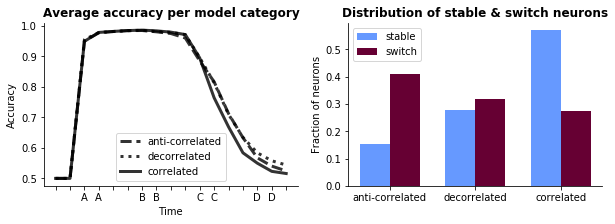

In [185]:
rnn_folder = 'models/75-25_100models/'

arr_diag = np.arange(11, 17)
n_stable_arr = {x: [] for x, val in corr_names.items()}
n_switch_arr = {x: [] for x, val in corr_names.items()}
ratio_stable_switch_arr = {x: [] for x, val in inds_sel.items()}
dec_accuracy_arr = {x: [] for x, val in inds_sel.items()}
dec_diag_accuracy_arr = {x: [] for x, val in inds_sel.items()}
list_rnns = [x for x in os.listdir(rnn_folder) if x[-5:] == '.data']

assert len(inds_sel['low']) + len(inds_sel['med']) + len(inds_sel['high']) == summ_accuracy.shape[0]

for key, inds_selection in inds_sel.items():
    for i_rnn, ind_rnn in enumerate(inds_selection):
        rnn_name = list_rnns[ind_rnn]
        with open(rnn_folder + rnn_name, 'rb') as f:
            rnn = pickle.load(f)
        dec_accuracy_arr[key].append(rnn.decoding_crosstemp_score[train_times, :][:, test_times].mean((0, 1)))
        dec_diag_accuracy_arr[key].append(np.median(rnn.decoding_crosstemp_score[arr_diag, arr_diag]))
        n_st_sw = ru.find_stable_switch_neurons(rnn=rnn)[0]
        n_stable_arr[key].append(n_st_sw[0])
        n_switch_arr[key].append(n_st_sw[1])
        ratio_stable_switch_arr[key].append(n_st_sw[0] / (n_st_sw[0] + n_st_sw[1]))
    dec_accuracy_arr[key] = np.array(dec_accuracy_arr[key])
assert (dec_accuracy_arr['low'].max() < low_bound) and (dec_accuracy_arr['high'].min() > high_bound)
assert (dec_accuracy_arr['med'].max() < high_bound) and (dec_accuracy_arr['med'].min() > low_bound)

## Plotting
plt.rcParams['figure.figsize'] = (10, 3)
ax_distr_acc = plt.subplot(121)
tmp_dict = {x: [] for x in ['split', 'acc']}
linestyle_dict = {'low': '--', 'med': ':', 'high': '-'}
for key, distr in dec_diag_accuracy_arr.items():
    tmp_dict['split'] += [corr_names[key]] * len(distr)
    tmp_dict['acc'] += list(distr)
    plt.plot(agg_score_use[inds_sel[key], :, :][:, np.arange(agg_score_use.shape[1]), np.arange(agg_score_use.shape[2])].mean(0),
             label=corr_names[key], linewidth=3,alpha=0.8,
             color='k', linestyle=linestyle_dict[key])
ax_distr_acc.legend(loc='best')
ax_distr_acc.set_xticks(np.arange(17))
ax_distr_acc.set_xticklabels(double_time_labels_blank[:-1])
ax_distr_acc.set_xlabel('Time'); ax_distr_acc.set_ylabel('Accuracy')
ax_distr_acc.set_title('Average accuracy per model category', weight='bold')
# ax_distr_acc.set_xlim([8, 17])
ax_bar = plt.subplot(122)
bar_locs = np.arange(len(inds_sel))
bar_width = 0.35  # for 2

# Compute summaries
sum_stable = [np.sum(val) for _, val in n_stable_arr.items()]
sum_switch = [np.sum(val) for _, val in n_switch_arr.items()]
norm_sum_stable = [x / np.sum(sum_stable) for x in sum_stable]
norm_sum_switch = [x / np.sum(sum_switch) for x in sum_switch]

bar_stable = ax_bar.bar(bar_locs - bar_width / 2, norm_sum_stable,
                     width=bar_width, label='stable', color='#6699FF')
bar_switch = ax_bar.bar(bar_locs + bar_width / 2, norm_sum_switch,
                     width=bar_width, label='switch', color='#660033')
ax_bar.set_xticks(bar_locs)
ax_bar.set_xticklabels(['anti-correlated', 'decorrelated', 'correlated'], rotation=0) # ax_bar.set_xticklabels(inds_sel.keys())
ax_bar.legend(); plt.ylabel('Fraction of neurons'); 
plt.title('Distribution of stable & switch neurons', weight='bold')
sns.despine()
plt.savefig('figures/stable_switch_correlated.pdf', bbox_inches='tight')

Mean: 0.43


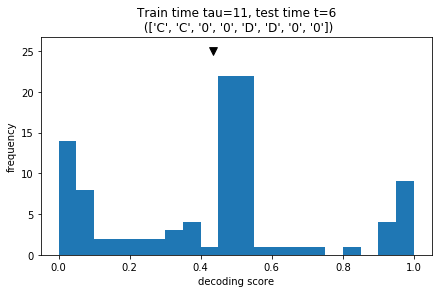

In [26]:
plt.rcParams['figure.figsize'] = (7, 4)
train_time = 11
test_time = 6
hist_arr = agg_score[90][:, train_time, test_time]
plt.hist(hist_arr, bins=np.linspace(0, 1, 21));
plt.scatter(np.mean(hist_arr), 25, marker='v', color='k', s=60)
print(f'Mean: {np.round(np.mean(hist_arr), 2)}')
plt.xlabel('decoding score'); plt.ylabel('frequency'); 
plt.title(f'Train time tau={train_time}, test time t={test_time}\n ({double_time_labels[train_time-1:]})');

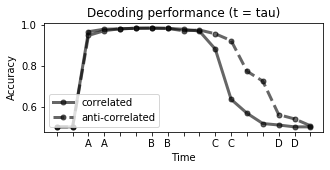

In [182]:
plt.rcParams['figure.figsize'] = (5, 2)
ax_hl = plt.subplot(111)
ax_hl.plot(np.diag(rnn.decoding_crosstemp_score), linewidth=3, label=corr_names['high'],
         linestyle='-', marker='.', markersize=10, color='k', alpha=0.6)
ax_hl.plot(np.diag(rnn_l.decoding_crosstemp_score), linewidth=3, label=corr_names['low'],
         linestyle='--', marker='.', markersize=10, color='k', alpha=0.6)
ax_hl.legend(loc='lower left'); ax_hl.set_xticks(np.arange(17))
ax_hl.set_xticklabels(double_time_labels_blank[:-1])
ax_hl.set_xlabel('Time'); ax_hl.set_ylabel('Accuracy');
ax_hl.set_title('Decoding performance (t = tau)')
# sns.despine()
plt.savefig('figures/example_high_low_accuracies.pdf', bbox_inches='tight')

In [162]:
n_stable_arr, n_switch_arr = {}, {}
for key, inds_selection in inds_sel.items():
    n_stable_arr[key], n_switch_arr[key] = [], []
    print(f'=------\n{key}\n-----')
    for i_rnn, ind_rnn in enumerate(inds_selection):
        rnn_name = list_rnns[ind_rnn]
        with open(rnn_folder + rnn_name, 'rb') as f:
            rnn = pickle.load(f)
        _, __, forw  = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5, sparsity_c=0.1)
        n_st_sw = ru.find_stable_switch_neurons_activity(forw_mat=forw, diff_th=0.5)[0]
        n_stable_arr[key].append(n_st_sw[0])
        n_switch_arr[key].append(n_st_sw[1])

=------
low
-----


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Conver

=------
med
-----


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Conver

=------
high
-----


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Conver

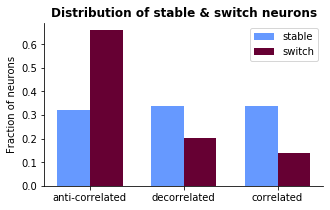

In [183]:
plt.rcParams['figure.figsize'] = (5, 3)
ax_bar = plt.subplot(111)

bar_locs = np.arange(len(inds_sel))
bar_width = 0.35  # for 2

sum_stable = [np.mean(val) for _, val in n_stable_arr.items()]
sum_switch = [np.mean(val) for _, val in n_switch_arr.items()]
norm_sum_stable = [x / np.sum(sum_stable) for x in sum_stable]
norm_sum_switch = [x / np.sum(sum_switch) for x in sum_switch]

bar_stable = ax_bar.bar(bar_locs - bar_width / 2, norm_sum_stable,
                     width=bar_width, label='stable', color='#6699FF')
bar_switch = ax_bar.bar(bar_locs + bar_width / 2, norm_sum_switch,
                     width=bar_width, label='switch', color='#660033')
ax_bar.set_xticks(bar_locs)
ax_bar.set_xticklabels(['anti-correlated', 'decorrelated', 'correlated'], rotation=0) # ax_bar.set_xticklabels(inds_sel.keys())
ax_bar.legend(); plt.ylabel('Fraction of neurons'); 
plt.title('Distribution of stable & switch neurons', weight='bold')
sns.despine()
# plt.savefig('figures/stable_switch_correlated.pdf', bbox_inches='tight')

In [171]:
test_times
kkk = 0

0.5742254377115961


Text(0.5, 1, 'Cross-temporal decoding score\nCorrelated single example')

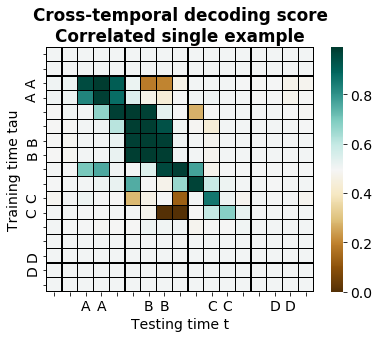

In [220]:
rnn_folder = 'models/75-25_100models/'
# list_rnns = [x for x in os.listdir(rnn_folder) if x[-5:] == '.data']
# OLD
# print(kkk)
# rnn_name = list_rnns[inds_sel['med'][15]]
# rnn_name = list_rnns[inds_sel['low'][6]]
# rnn_name = list_rnns[inds_sel['high'][2]]

## NEW
rnn_name = list_rnns[inds_sel['med'][21]]
# rnn_name = list_rnns[inds_sel['low'][3]]
# rnn_name = list_rnns[inds_sel['high'][3]]
with open(rnn_folder + rnn_name, 'rb') as f:
    rnn = pickle.load(f)
# with open(rnn_folder + rnn_name_l, 'rb') as f:
#     rnn_l = pickle.load(f)
print(rnn.decoding_crosstemp_score[train_times, :][:, test_times].mean())


plt.rcParams['figure.figsize'] = (6, 4.5)
pr.plot_decoder_crosstemp_perf(score_matrix=rnn.decoding_crosstemp_score, 
                               ax=plt.subplot(111), 
                               ticklabels=double_time_labels_blank[:-1])
plt.title('Cross-temporal decoding score\nCorrelated single example', weight='bold')
# plt.savefig('figures/example_high_crosstempmat.pdf', bbox_inches='tight')
# kkk += 1

In [221]:
rnn.decoding_crosstemp_score[train_times, :][:, test_times]

array([[0.54315738, 0.96441433],
       [0.49902338, 0.4740334 ],
       [0.46791284, 0.49681131]])

In [222]:
_, __, forw  = bp.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5, sparsity_c=0.1)

In [223]:
# plt.rcParams['figure.figsize'] = (6, 6)
tmp  = ru.find_stable_switch_neurons_activity(forw_mat=forw, diff_th=0.5)
print(tmp[0])
# np.sort(ol[tmp[1][0]])

(8, 1)


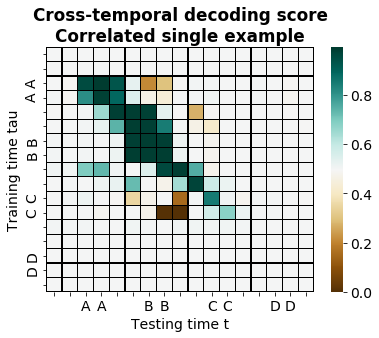

In [224]:

plt.rcParams['figure.figsize'] = (6, 4.5)
pr.plot_decoder_crosstemp_perf(score_matrix=rnn.decoding_crosstemp_score, 
                               ax=plt.subplot(111), 
                               ticklabels=double_time_labels_blank[:-1])
plt.title('Cross-temporal decoding score\nCorrelated single example', weight='bold')
plt.savefig('figures/example_med_crosstempmat.pdf', bbox_inches='tight')


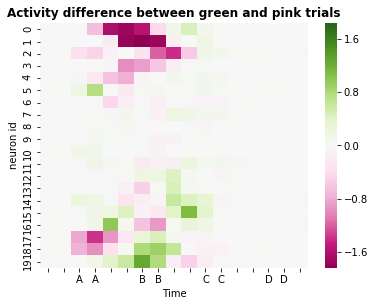

In [225]:
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['font.size'] = 10
labels_use_1 = np.array([x[0] == '1' for x in forw['labels_train']])
labels_use_2 = np.array([x[0] == '2' for x in forw['labels_train']])

plot_diff = (forw['train'][labels_use_1, :, :].mean(0) - forw['train'][labels_use_2, :, :].mean(0))
ol = pr.opt_leaf(plot_diff, dim=1)
# ol = np.argsort(plot_diff.sum(0))
rev_ol = np.zeros_like(ol)
for i_ol, el_ol in enumerate(ol):
    rev_ol[el_ol] = i_ol
plot_diff = plot_diff[:, ol]
th = np.max(np.abs(plot_diff))
hm = sns.heatmap(plot_diff.T, cmap='PiYG', vmin=-1 * th, vmax=th, ax=plt.subplot(111),
                 xticklabels=double_time_labels_blank[:-1])
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Activity difference between green and pink trials', weight='bold')
plt.xlabel('Time'); plt.ylabel('neuron id');
# plt.savefig('figures/example_high_forward_difference.pdf', bbox_inches='tight')

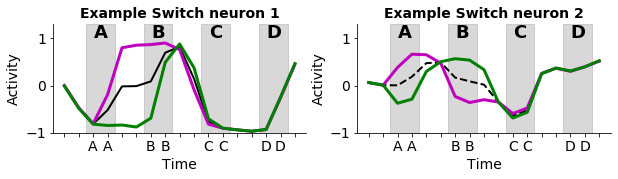

In [226]:
plt.rcParams['figure.figsize'] = (10, 2)
plt.rcParams['font.size'] = 14
ax_diff_single = {}
def plot_neuron_diff(ax_select, act_1, act_2, mean_ls='-'):
    ax_select.axvspan(xmin=1.5, xmax=3.5, color='grey', alpha=0.3)
    ax_select.axvspan(xmin=5.5, xmax=7.5, color='grey', alpha=0.3)
    ax_select.axvspan(xmin=9.5, xmax=11.5, color='grey', alpha=0.3)
    ax_select.axvspan(xmin=13.5, xmax=15.5, color='grey', alpha=0.3)
    ax_select.plot((act_1 + act_2) / 2, linewidth=2, linestyle=mean_ls, c='k')
    ax_select.plot(act_2, linewidth=3, c='m');
    ax_select.plot(act_1, c='g', linewidth=3);
    ax_select.set_xticks(np.arange(forw['train'].shape[1]));
    ax_select.set_xlabel('Time'); ax_select.set_ylabel('Activity')
    ax_select.set_xticklabels(double_time_labels_blank[:-1]);
    ax_select.set_ylim([-1, 1.3])
    for i_letter, letter in enumerate(['A', 'B', 'C', 'D']):
        ax_select.text(s=letter, x=2.02 + 4 * i_letter, y=1.01, 
                       fontdict={'weight': 'bold', 'fontsize': 18})
    sns.despine()
    return ax_select
    
activity_1, activity_2 = {}, {}
mean_ls_dict = {0: '-', 1: '--'}
## High: 19 & 2
## Low: 0 & 19

for i_plot, n_neuron in enumerate([ol[0], ol[18]]):
    ax_diff_single[i_plot] = plt.subplot(1, 2, i_plot + 1)
    activity_1[n_neuron] = forw['train'][labels_use_1, :, :][:, :, n_neuron].mean(0)
    activity_2[n_neuron] = forw['train'][labels_use_2, :, :][:, :, n_neuron].mean(0)
    ax_diff_single[i_plot] = plot_neuron_diff(ax_select=ax_diff_single[i_plot], 
                                              act_1=activity_1[n_neuron], 
                                              act_2=activity_2[n_neuron],
                                              mean_ls=mean_ls_dict[i_plot])
    if i_plot == 0:
        ax_diff_single[i_plot].set_title('Example Switch neuron 1', weight='bold',
                                         fontsize=14)
    if i_plot == 1:
        ax_diff_single[i_plot].set_title('Example Switch neuron 2', weight='bold',
                                         fontsize=14)
plt.savefig('figures/example_med_neurons_stabl-switch.pdf', bbox_inches='tight')

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


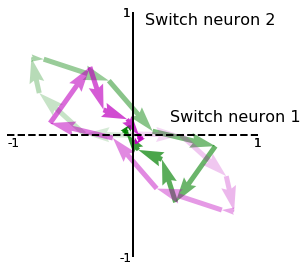

In [219]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)
max_tp = 17
n1 = list(activity_1.keys())[0]
n2 = list(activity_1.keys())[1]
mean_n1 = (activity_1[n1] + activity_2[n1]) / 2
mean_n2 = (activity_1[n2] + activity_2[n2]) / 2
plt.plot([-1, 1], [0, 0], c='k', linewidth=2, linestyle=mean_ls_dict[1])  # x axis - so correpsonding to neuron on y axis
plt.plot([0, 0], [-1, 1], c='k', linewidth=2, linestyle=mean_ls_dict[0])  # y axis - so correspond to neuron on x axis

def plot_arrow_line(x, y, ax=None, c='blue'):
    if ax is None:
        ax = plt.subplot(111)
    c_mat = np.zeros((len(x) - 1, 4))
    if c == 'green':
        c_mat[:, 1] = 0.5
    elif c == 'm':
        c_mat[:, (0, 2)] = 0.746
    else:
        c_mat[:, 0] = 0.8
    c_mat[:, 3] = np.linspace(0.1, 1, len(x) - 1) 
    ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], width=.02,
              scale_units='xy', angles='xy', scale=1, color=c_mat)
    ax.set_axis_off()
    ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1])
    ax.text(s='1', x=0.96, y=-0.1, fontdict={'fontsize': 12})
    ax.text(s='1', x=-0.08, y=0.96, fontdict={'fontsize': 12})
    ax.text(s='-1', x=-1, y=-0.1, fontdict={'fontsize': 12})
    ax.text(s='-1', x=-0.11, y=-1.04, fontdict={'fontsize': 12})
    return ax

plot_arrow_line(activity_1[n1][:max_tp] - mean_n1[:max_tp], 
         activity_1[n2][:max_tp] - mean_n2[:max_tp], c='green')

ax_ss = plot_arrow_line(activity_2[n1][:max_tp] - mean_n1[:max_tp], 
         activity_2[n2][:max_tp] - mean_n2[:max_tp], c='m')
# ax_ss.set_title('State space', weight='bold')
ax_ss.text(s='Switch neuron 1', x=0.3, y=0.1,
           fontdict={'fontsize': 16})

ax_ss.text(s='Switch neuron 2', x=0.1, y=0.9,
           fontdict={'fontsize': 16})

plt.savefig('figures/example_low_statespace_switch-switch.pdf', bbox_inches='tight')

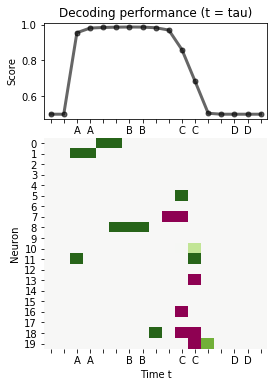

In [213]:
plt.rcParams['figure.figsize'] = (4, 6)
_, __ = pr.plot_dynamic_decoding_axes(rnn=rnn, ticklabels=double_time_labels_blank[:-1])
plt.savefig('figures/example_low_decodingweights.pdf', bbox_inches='tight')

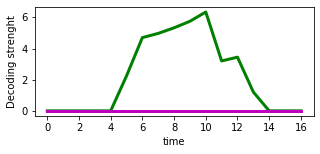

In [90]:
plt.rcParams['figure.figsize'] = (5, 2)

_  = pr.plot_time_trace_1_decoding_neuron(rnn=rnn)

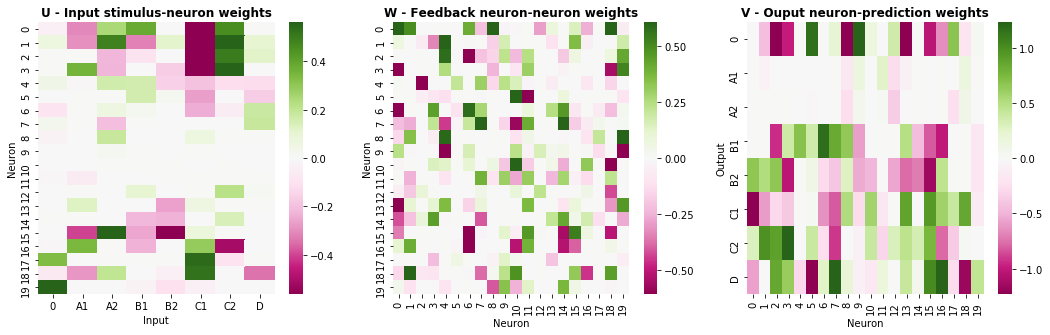

In [89]:

plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=w_order)